## Project 2 - Udacity Self-Driving Car Nanodegree
---
### Advanced Lane Finding

The code in this project finds lane lines in a video stream
The following steps are taken:

1. Calibrate the camera, calculate the distortion coefficients and undistort the road images as well as the chessboard images
2. Detect edges on the undistorted road images by combining different image gradients
3. Define an area of interest for the lane lines
4. Perform a perspective transform into birds-eye view to look at the area of interest from above
5. Find the lane lines doing a histogram search
6. Project the lane lines onto the original image

In [1]:
# Import resources and libraries
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

---

#### 1. Camera Calibration

Calibrate the camera using chessboard images provided in folder `/camera_cal`

In [2]:
# Arrays to store the object points (3D points in real world space) 
# and image points (2D points in image plane) from all images
objpoints = []
imgpoints = []

# Prepare the object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Read all calibration images into a list
images = glob.glob('camera_cal/*.jpg')

# Iterate through every image and perform the calibration steps
for image in images:
    # Read in the image
    img = mpimg.imread(image)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If corners are found, add them to object and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

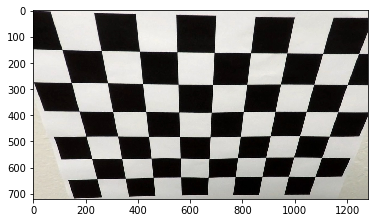

In [3]:
# Determine the image size of one of the calibration images
img = mpimg.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Determine the distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Undistort image
img_undistort = cv2.undistort(img, mtx, dist, None, mtx)

plt.imshow(img_undistort)

\
Calculate the distortion coefficients, undistort the road images and the chessboard images and save them to 
the folder `/output_images/1_undistorted`

In [3]:

# Empty list to hold the images that need processing
im_list = []

# Function to load all images with their corresponding filename into a list
def load_image(src_dir):
    # Iterate through every image in the image directory and append it to the image list
    # works for .jpg or .png files
    for file in os.listdir(src_dir):
        if file.endswith(".jpg") or file.endswith(".png"):
            img = mpimg.imread(src_dir + file)
            im_list.append((img, file))
            
    return im_list
    
# Uncomment next line to load road images      
#load_image('test_images/')

# Uncomment next line to load chessboard images      
#load_image('camera_cal/')

# Undistort the images in the image list
for image in im_list:
    storage = cv2.undistort(image[0], mtx, dist, None, mtx)
    plt.imsave('output_images/1_undistorted/' + image[1], storage)

---

#### Load original image
Image processing will be done on this picture

In [4]:
image = mpimg.imread('output_images/1_undistorted/test3.jpg')

---

#### 2. Edge Detection
Calculate the gradient of the undistorted road images in order to identify edges. \
The gradient is computed using a mixture of different thresholding techniques either applied to a grayscale or HSL color space conversion of the undistorted image.

**_-->Run cell below for the video pipeline to work<--_**

In [5]:
# Function to compute the image binaries
def compute_binaries(img, orient='x', sobel_kernel=3, grad_thresh=(0, 255), mag_thresh=(0, 255), 
                     dir_thresh=(0, np.pi/2), s_thresh=(0, 255), l_thresh=(0, 255)): 

    # Calculate the gradient in x- or y-direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)

    if orient == 'x':
        abs_sobel = np.absolute(sobelx)
    if orient == 'y':
        abs_sobel = np.absolute(sobely)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1


    # Calculate the gradient in x- and y-direction 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    abs_sobel = np.absolute(sobelx + sobely)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    

    # Calculate the gradient in a specified direction between 0 and pi/2
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
   

    # Calculate the gradient using the S and L channels of HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channels
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Combine the color channels
    sl_binary = np.zeros_like(s_binary)
    sl_binary[(s_binary == 1) | (l_binary == 1)] = 1
    
    
    # Stack color binary and magnitude binary
    mag_dir_binary = np.zeros_like(dir_binary)
    mag_dir_binary[((mag_binary == 1) & (dir_binary == 1))] = 1
    stacked_binary = np.dstack(( np.zeros_like(mag_binary), mag_dir_binary, sl_binary)) * 255


    # Combine the gradients of x- and y-direction with gradients of of L and S channel
    # I found this to be the best working thresholding combination
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((mag_binary == 1) & (dir_binary == 1)) | (sl_binary == 1)] = 1
    
    
    return stacked_binary, combined_binary

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


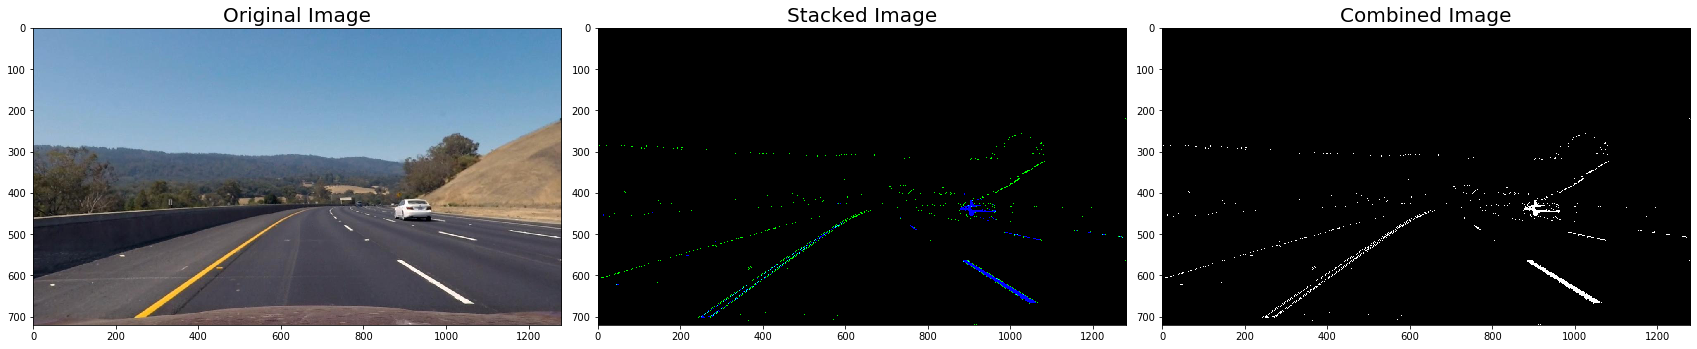

In [6]:
stacked_binary, combined_binary = compute_binaries(image, orient='x', sobel_kernel=7, grad_thresh=(40, 100), 
                                                            mag_thresh=(50, 100), dir_thresh=(0.7, 1.3), 
                                                            s_thresh=(170, 225), l_thresh=(220, 255))


# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(stacked_binary)
ax2.set_title('Stacked Image', fontsize=20)
ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined Image', fontsize=20)
f.tight_layout()
plt.subplots_adjust(left=0.03, right=0.989, top=0.95, bottom=0.044)

---
\
Apply edge detection on all road images and save them to the folder `/output_images/2_edge`

In [16]:
# Empty list to hold the images that need processing
im_list = []

# Function to load all images with their corresponding filename into a list
def load_image(src_dir):
    # Iterate through every image in the image directory and append it to the image list
    # works for .jpg or .png files
    for file in os.listdir(src_dir):
        if file.startswith("test") or file.startswith("straight"):
            img = mpimg.imread(src_dir + file)
            im_list.append((img, file))
            
    return im_list

load_image('output_images/1_undistorted/')

for image in im_list:
    storage = compute_binaries(image[0], orient='x', sobel_kernel=7, grad_thresh=(40, 100), 
                                                            mag_thresh=(30, 100), dir_thresh=(0.7, 1.3), 
                                                            s_thresh=(170, 255), l_thresh=(210, 255))[1]
    
    plt.imsave('output_images/2_edge/' + image[1], storage, cmap='gray')

---

#### 3. Determine a area of interest on a straight line image

Choose a centered image with straight lane lines and draw a trapezoid on it in order to determine the source points for the area of interest and the perspective transform

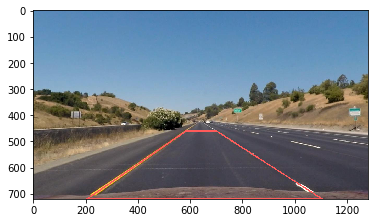

In [7]:
img = mpimg.imread('output_images/1_undistorted/straight_lines1.jpg')

vertices = np.array([[(205,720),(585, 460), (700, 460), (1105,720)]], dtype=np.int32)
draw = np.copy(img)
cv2.polylines(draw, vertices, 1, (255, 90, 90), 3)
plt.imshow(draw)

---

#### 4. Perform a perspective transform

Perform a perspective transform into birds-eye view with the source points from above

**_-->Run cell below for the video pipeline to work<--_**

In [8]:
# Four source points
src = np.float32([(205,720),(585, 460), (700, 460), (1105,720)])

# Four desired points
dst = np.float32([(230, 720), (250, 0), (980, 0), (1000, 720)])

# Define perspective transform function
def warp(img, src, dst):
  
    # Define calibration box in source and destination coordinates
    img_size = (img.shape[1], img.shape[0])
  
    # Compute the perspective transform, M and the inverse perspective transform Minv
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
  
    # Create warped image 
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
  
    return warped, Minv

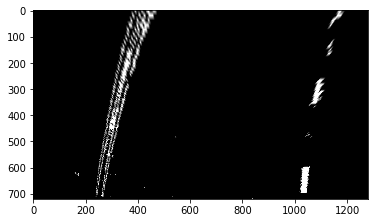

In [9]:
binary_warped, Minv = warp(combined_binary, src, dst)

plt.imshow(binary_warped, cmap='gray')

---
\
Perform perspective transform on all edge images and store them in the folder `/output_images/3_perspective_transform`

In [9]:
# Empty list to hold the images that need processing
im_list = []

# Function to load all images with their corresponding filename into a list
def load_image(src_dir):
    # Iterate through every image in the image directory and append it to the image list
    # works for .jpg or .png files
    for file in os.listdir(src_dir):
        if file.endswith(".jpg") or file.endswith(".png"):
            img = mpimg.imread(src_dir + file)
            im_list.append((img, file))
            
    return im_list

load_image('output_images/2_edge/')

for image in im_list:
    storage = warp(image[0], src, dst)[0]
    plt.imsave('output_images/3_perspective_transform/' + image[1], storage, cmap='gray')

---

#### 5. Find the lane pixels using histogram peak search

Determine the left and right lane lines using a histogram peak search and fitting a 2nd degree polynominal through the detected pixles

**_-->Run cell below for the video pipeline to work<--_**

In [10]:
def find_lane_pixels(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped, warped, warped))

    # Find the midpoint of the image and the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Number of sliding windows for each lane 
    nwindows = 15
    # Width of the windows +/- margin
    margin = 60
    # Minimum number of pixels that have to be found in order to recenter the window
    minpix = 50

    # Height of windows - based on nwindows and image shape
    window_height = np.int(warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = np.nonzero(warped)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through each window one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [11]:
def fit_polynomial(warped):
    # Find the lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    
    # Fit a second order polynominal through the left and right line pixel positions
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate the y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

    # Calculate the x values for plotting based on `x = f(y) = Ay^2 + By + C
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

   
    return ploty, left_fitx, right_fitx, left_fit, right_fit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


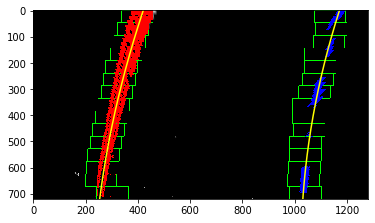

In [12]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomial(binary_warped)

# Color in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plot the polynomial in yellow color
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


plt.imshow(out_img)

---

#### 6. Draw the lane lines onto the original image 

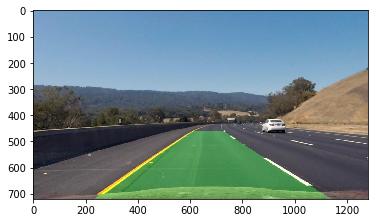

In [13]:
# Get the lane pixels
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

# Plot onto the original image
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)

# Uncomment to save the image to the hard drive
#plt.imsave('output_images/5_final/final.jpg', result)

---

#### 7. Calculate the lane curvature and vehicle offset

In [14]:
def measure_curvature_real():
    # Conversion ratios in x- and y-direction from pixels space to meters
    ym_per_pix = 20/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/770 # meters per pixel in x dimension -> adjusted according to perspective transform
    
    # Obtain the polynomial data
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Convert values
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)   
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = binary_warped.shape[0] / 2
    
    # Calculation of Rradius of curvature 
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2) / np.absolute(2*left_fit_cr[0]))
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2) / np.absolute(2*right_fit_cr[0]))
    
    # Calculate average curvature
    avg_curvrad = (left_curverad + right_curverad) / 2
    
    return round(left_curverad, 2), round(right_curverad, 2) , round(avg_curvrad, 2)


left_curverad, right_curverad, avg_curvrad = measure_curvature_real()

print(left_curverad, 'm', '|', right_curverad, 'm', '|', avg_curvrad, 'm')

873.16 m | 869.73 m | 871.45 m


In [15]:
def measure_offset():
    xm_per_pix = 3.7/770 # meters per pixel in x dimension -> adjusted according to perspective transform
    
    # Obtain the polynomial values for the left lane and right lane
    left_fitx = fit_polynomial(binary_warped)[1]
    right_fitx = fit_polynomial(binary_warped)[2]
    
    # Calculate lane width at the bottom of the image
    lane_width = right_fitx[binary_warped.shape[0]-1] - left_fitx[binary_warped.shape[0]-1]
    
    # Calculate the lane center
    lane_center = lane_width / 2 + left_fitx[binary_warped.shape[0]-1]
    
    # Determine the image center
    image_center = binary_warped.shape[1] / 2
    
    # Calculate vehicle offset
    offset = lane_center - image_center
    
    # Convert from pixel space to metric space
    offset *= xm_per_pix
    
    return round(offset, 2)


offset = measure_offset()

print('Vehicle offset', offset)

Vehicle offset 0.01


---

### Apply the pipeline to the video

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Function to search around the previous polynomial
Does not start the lane pixel search from scratch but instead searches lane pixels around the left lane and right lane polynomial from the previous frame 

In [17]:
def search_around_poly(warped):
    # Polynomial coefficients 
    left_fit = leftline_current_fit
    right_fit = rightline_current_fit
  
    # Margin to search around the previous polynomial
    margin = 60

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Define the area of search
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

**Lane Tracking**

Initiate an object of the class `Line`for each the left lane line and the right lane line to keep track of the lane charecteristics 

In [18]:
import tracking
import statistics 

In [19]:
# Instance for the left lane line
Leftline = tracking.Line()

# Instance for the right lane line
Rightline = tracking.Line()

In [20]:
## Initiate tracking objects

# polynomial coefficients averaged over the last n iterations
leftline_poly_avgA = Leftline.best_fitA
leftline_poly_avgB = Leftline.best_fitB
leftline_poly_avgC = Leftline.best_fitC
rightline_poly_avgA = Rightline.best_fitA
rightline_poly_avgB = Rightline.best_fitB
rightline_poly_avgC = Rightline.best_fitC

# polynomial coefficients for the most recent fit
leftline_current_fit = Leftline.current_fit
rightline_current_fit = Rightline.current_fit

**Pipeline to run on the video stream**

In [21]:
## Parameters for image thresholding
orient = 'x'
sobel_kernel =7 
grad_thresh = (40, 100)
mag_thresh = (50, 100)
dir_thresh = (0.7, 1.3) 
s_thresh = (170, 240)
l_thresh = (220, 255)


## Image points for perspective transform
# Source points
src = np.float32([(205,720),(585, 460), (700, 460), (1105,720)])
# Desired points
dst = np.float32([(230, 720), (250, 0), (980, 0), (1000, 720)])


# Conversion ratios in x- and y-direction from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/770 # meters per pixel in x dimension -> adjusted according to perspective transform


# Smoothing parameter
# smoothes the projection over the last n frames
smoothing = 7


# Counter to keep track of the frame number
frame_count = 0


def process_image(image):
    
    global frame_count
    global smoothing
    
    global leftline_det
    global leftline_poly_avgA
    global leftline_poly_avgB
    global leftline_poly_avgC
    global rightline_poly_avgA
    global rightline_poly_avgB
    global rightline_poly_avgC
    global leftline_current_fit
    global rightline_current_fit
    
    
    ########################
    ## Image thresholding ##
    ######################## 
    
    combined_binary = compute_binaries(image, orient, sobel_kernel, grad_thresh, mag_thresh, dir_thresh, s_thresh, l_thresh)[1]
    #stacked_binary = compute_binaries(image, orient, sobel_kernel, grad_thresh, mag_thresh, dir_thresh, s_thresh, l_thresh)[0]
    
    ###########################
    ## Perspective transform ##
    ###########################
    
    binary_warped, Minv = warp(combined_binary, src, dst)
    
    
    ######################
    ## Find lane pixels ##
    ######################
    
    if frame_count == 0:
        leftx = find_lane_pixels(binary_warped)[0]
        lefty = find_lane_pixels(binary_warped)[1]
        rightx = find_lane_pixels(binary_warped)[2]
        righty = find_lane_pixels(binary_warped)[3]
    else:      
        leftx = search_around_poly(binary_warped)[0]
        lefty = search_around_poly(binary_warped)[1]
        rightx = search_around_poly(binary_warped)[2]
        righty = search_around_poly(binary_warped)[3]
 
    
    ########################################
    ## Fit polynomial through lane pixels ##
    ########################################
    
    # Fit a second order polynominal through the left and right line pixel positions
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Smoothing / averaging the left_fit values
    leftline_poly_avgA.append(left_fit[0])
    leftline_poly_avgA = leftline_poly_avgA[-smoothing:]
    
    leftline_poly_avgB.append(left_fit[1])
    leftline_poly_avgB = leftline_poly_avgB[-smoothing:]
    
    leftline_poly_avgC.append(left_fit[2])
    leftline_poly_avgC = leftline_poly_avgC[-smoothing:]
    
    left_smoothA = statistics.mean(leftline_poly_avgA)
    left_smoothB = statistics.mean(leftline_poly_avgB)
    left_smoothC = statistics.mean(leftline_poly_avgC)
    
    left_smooth = []
    left_smooth.append((left_smoothA, left_smoothB, left_smoothC))

    # Smoothing / averaging the right_fit values
    rightline_poly_avgA.append(right_fit[0])
    rightline_poly_avgA = rightline_poly_avgA[-smoothing:]
    
    rightline_poly_avgB.append(right_fit[1])
    rightline_poly_avgB = rightline_poly_avgB[-smoothing:]
    
    rightline_poly_avgC.append(right_fit[2])
    rightline_poly_avgC = rightline_poly_avgC[-smoothing:]
    
    right_smoothA = statistics.mean(rightline_poly_avgA)
    right_smoothB = statistics.mean(rightline_poly_avgB)
    right_smoothC = statistics.mean(rightline_poly_avgC)
    
    right_smooth = []
    right_smooth.append((right_smoothA, right_smoothB, right_smoothC))

    # Generate the y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Calculate the x values for plotting based on `x = f(y) = Ay^2 + By + C
    left_fitx = left_smooth[0][0]*ploty**2 + left_smooth[0][1]*ploty + left_smooth[0][2]
    right_fitx = right_smooth[0][0]*ploty**2 + right_smooth[0][1]*ploty + right_smooth[0][2]
        
    
    #######################
    ## Measure curvature ##
    #######################
    
    # Convert values
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)   
    
    # Calculate radius of curvature at the bottom of the image
    y_eval = binary_warped.shape[0]
    
    # Calculation of Rradius of curvature 
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2) / np.absolute(2*left_fit_cr[0]))
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2) / np.absolute(2*right_fit_cr[0]))
    
    # Calculate average curvature
    avg_curvrad = round((left_curverad + right_curverad) / 2, 2)   
    
    
    ############################
    ## Measure vehicle offset ##
    ############################
    
    # Calculate lane width at the bottom of the image
    lane_width = right_fitx[binary_warped.shape[0]-1] - left_fitx[binary_warped.shape[0]-1]
    
    # Calculate the lane center
    lane_center = lane_width / 2 + left_fitx[binary_warped.shape[0]-1]
    
    # Determine the image center
    image_center = binary_warped.shape[1] / 2
    
    # Calculate vehicle offset
    offset = round((lane_center - image_center) * xm_per_pix, 2)
        
    
    ###################################
    ## Store polynomial coefficients ##
    ###################################
    
    leftline_current_fit = left_fit
    rightline_current_fit = right_fit
        
    
    ##################################
    ## Draw onto the original image ##
    ##################################
    

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Print vehicle offset and lane curvature on the video
    cv2.putText(result, ('Lane curvature: ' + str(avg_curvrad) + 'm'), (40,70), 0, 1, (255,255,117), 2)
    cv2.putText(result, ('Vehicle offset: ' + str(offset)), (40,120), 0, 1, (255,255,117), 2)
    

    frame_count += 1
    
    
    return result

In [21]:
white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(38,43)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 2/1260 [00:00<02:02, 10.30it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 3min 20s, sys: 59.3 s, total: 4min 19s
Wall time: 4min 10s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))